# PetroGG Adapted for NMR Shaly-Sand Petrophysical Data 

### Introduction

###### This repository started with PetroGG written by Mihai in GitHub that has been modified to be used with our Gulf of Mexico NMR shaly-sand example data. These data are in the NMR.txt text file provided. PetroGG provides for an excellent foundation for our work. We appreciate all the fine work of Mihai on PetroGG and the suitability of his code to be expanded upon for this application of PetroGG. 

###### We have made a few changes to PetroGG. First of all, we have modified the code to use Vshale and not Vclay as was previously employed. Almost all shales have less than 100% clay volume. We have personally sampled some of the greasiest, gumbo shales to find that the maximum clay content was only about 65% according to the XRD or FTIR mineralogy results. Therefore, estimating the endpoint parameters for clay points is a challenge since these 100% clay points are imaginary points and do not exist in the data. Instead we use shale point parameters which can be determined from most shaly-sands data sets. However, with sufficient mineralogy data from core samples or elemental log data like Schlumberger's Elemental Capture Spectroscopy (ECS) we can model the volume of clay for future applications. 

###### We have included two additional Saturation models suitable for shaly-sand analysis. Mihai has another excellent repository with various Petrophysical routines including saturation models. We started with his Waxman-Smits and Dual-Water saturation models from this repository and then made a few modifications for our saturation code found in this project. 

###### For Dual-Water we are using the George Coates (1) MRIAN method that was primarily used at Numar to integrate conventional log and NMR log data for the interpretation. NMR data has been found to be quite useful in assessing reservoir quality and defining the volume of non-movable Capillary Bound Water (MBVI). MBVI is quite different to the volume of Clay Bound Water (CBW) or CBW saturations (Swb) associated with the waters chemically bound to the shales. CBW is determined from the difference between Total (PHIT) and Effective (PHIE) porosity. 

###### In this example we are using NMR data from the older Numar tool that was only capable of measuring a NMR effective porosity (MPHI) and NMR Bulk Volume Irreducible (MBVI) in the effective porosity system. This tool did not have the capability at this point to employ the PR06 activation for the determination of the volume of Clay Bound Water (CBW). 

###### MBVI is calculated from the NMR T2 distribution by partitioning this T2 distribution into MBVI and Free Fluid (FFI). FFI pore volume has larger pores with movable fluid where MBVI has smaller pores with non-movable fluids. This partition point is called the T2 Cutoff and for this clastic well the T2 Cutoff was 33ms. We typically compare our log analysis based Bulk Volume Water in the effective porosity system (BVWe) to MBVI, in the effective porosity system, to determine what intervals have hydrocarbon saturations at irreducible water saturation with no movable water. When BVWe is higher than MBVI, then we expect some movable water depending on the relative permeability of these fluids. The next repository will cover this application in detail. 

###### For our Waxman-Smits saturation model we use the Hill, Shirley and Klein technique(2) to solve for Qv from Swb as shown below:

    Qv = Swb/(0.6425/((Fluid_Density*Salinity(kppm))**0.5) + 0.22) 

###### We then use the Waxman-Smits saturation equation provided by Crain in lieu of an iterative approach. 

###### We have found that Waxman-Smits method is a bit more flexible to use in shaly-sand interpretations in that we can model the Waxman-Smits cementation exponent m* to vary with Swb according to the trends observed in the wet intervals from our Swb vs. apparent m* cross plot as shown below.  Apparent m* increases as Swb increases in the wet intervals which leads to less apparent hydrocarbon saturations being calculated with higher Swb.  This is not true if one uses a constant m* for the analysis. The m* at Swb=0 y-intercept is the Archie m, but in this case m* increases with increased Swb. We have also found that a wrong Rw can lead to an unrealistic y-intercept to give us feedback on our choice of Rw too.

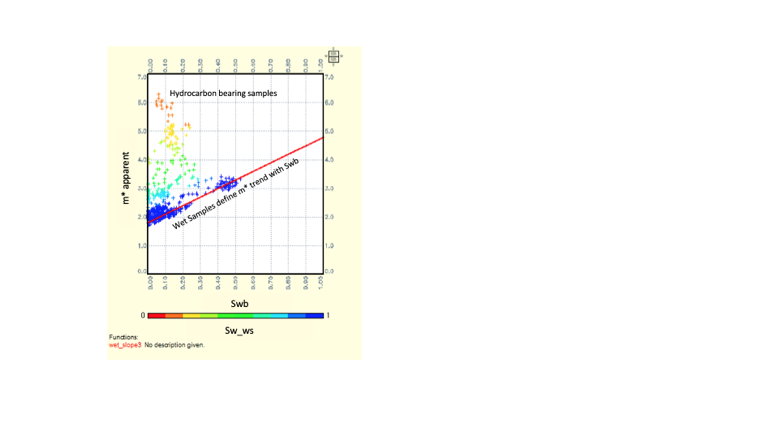

###### In the plot above we calculated the apparent m* data in another program to make this plot using the following equation:

    m* apparent = log10(Rw/(RT*(1+Rw*B*Qv)))/log10(PHIT)

###### This will be included in a future update.

### Data:

###### Log Data is found in GulfCoast_NMR.txt file

DEPTH	SP	GR	CALI	BitSize	LL8	ILM	ILD	RHOB	NPHI	DT	PHIX	RHOMAT	MBVI	MPHI

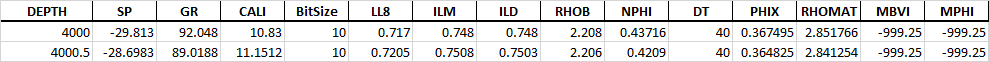

### Code:

#### Load Data

In [1]:
# -*- coding: utf-8 -*-
"""
Used Spyder Editor

"""

"""
===============================================================================
 Import data from text file into a pandas Dataframe called: ``data''.
 Null data (-999.00000) will be replace by numpy.nan and M__DEPTH changed 
 with DEPT (much common abrevation in las files)
===============================================================================
"""

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



data=pd.read_table('GulfCoast_NMR.txt', delim_whitespace=True, index_col='DEPTH')

# The following is from Atibalazs Issues reported on Nov 7, 2018
#data=pd.read_table('WA1.txt', delim_whitespace=True)
#data=data.replace(-999.00000,np.nan)
#data=data.rename(columns=({'M__DEPTH':'DEPT'}))


#data=data.replace('-999.00000',np.nan)
data=data.replace(-999.25,np.nan)

data=data.rename(columns=({'DEPTH':'DEPT'}))
data['DEPT']=data.index

#data['NPHI']=data['NPHI']-0.04  #if Neutron on SS matrix, convert to ls
data['NPHI']=data['NPHI']


#### Petrophysical Parameters to be used in the log analysis

In [2]:
"""
===============================================================================
           The following are the log parameter inputs for all calculations          
===============================================================================            

===============================================================================
 Shale and Porosity Parameters for many Calculations
    Mihai has a 100% clay point that I do not think is possible. 
    We use a 100% shale point 
===============================================================================
"""
gr_clean, gr_shale = 45, 120                                      # Shale Parmaetrs for GR
sp_clean, sp_shale = -50, 0                                       # Shale Parameters for SP
neut_shale, den_shale, por_shale = 0.39, 2.48, 0.24               # Shale Parmaters for Neutron-Density
neut_matrix, den_matrix = -0.02, 2.65                             # Matrix Parmameters for Neutron-Density
neut_fl, den_fl = 1.0, 1.1                                        # Fluid Parameters for Neutron-Density
dt_matrix, dt_fluid, dt_shale, cp, alpha = 55.5,188.0,90.0,1,5/8  # Sonic Parameters


"""
===============================================================================
                      Electrical Properties
===============================================================================

===============================================================================
 We need to define first the variables: m_cem, n_sat. You can start with this
 pair(m_cem=2,_satn=2) as it works well in most of lithologies. If your
 matrix is shaly-mixed, the you can decrease the m_cem to 1.8.
 ==============================================================================
 IMO turtuosity factor 'a' should be 1.0 at 100% porosity where FF = Ro/Rw = 1
 ==============================================================================
"""
m_cem = 2.0    #cementation factor
n_sat = 2.0    #saturation exponent

# Slope of Swb vs. Mstar apparent for Mstar across all Swb's
mslope = 3.

"""
===============================================================================
 Then choose the water resistivity: Rwa. We’ll plot log Resistivity vs.
 log Porosity in Pickett plot. Data can be selected just for the reservoir
 formations (excluding the shaly intervals) by working with the vsh_limit
 (volume of shale) variable.
===============================================================================
"""
T = 150.       # Reservoir temperature in DegF
TC=(T-32)/1.8  # Temp DegC
RwT = T        # Temperature of Rw measument
rwa=0.03       # water resistivity at RwT
vsh_limit=0.7  # volume of shale upper limit for selction of data for graph




#### Calculations made to be used with Waxman-Smits analysis

In [3]:
"""
 ===============================================================================
          Calculations used with Saturations
 ===============================================================================
"""
Rw75=((RwT+6.77)*rwa)/(75+6.77)

# Salinity in KPPM
SAL=(10**((3.562-math.log10(Rw75-0.0123))/0.955))/1000

B = math.exp(7.3-28.242/math.log(T)-0.2266*math.log(rwa)) 

Bdacy=(1-0.83*math.exp(-math.exp(-2.38+(42.17/TC))/rwa))*(-3.16+1.59*math.log(TC))**2 #SCA Paper SCA2006-29 (3)

print('Res temp =', T, 'Rw at Res Temp =',rwa, 'Rw@75 =', Rw75, 'B =',B, 'Bdacy =',Bdacy,'SAL =', SAL)      


Res temp = 150.0 Rw at Res Temp = 0.03 Rw@75 = 0.057516203986792226 B = 11.683469707767108 Bdacy = 12.157183503406632 SAL = 137.37633876842742


#### Define Plot Intervals

In [4]:
"""
===============================================================================
                    Major Zones of Interest
===============================================================================
===============================================================================
 a Main ZONE for analysis will be selected from the entire log. Program displays
 the logs again within the choosen interval with triple_combo_plot
 function.
 
 === Select zone of analysis: top and depth
 
 by setting the ``top_depth'' and ``bottom_depth'' variables
===============================================================================
"""
top_depth    = 4500
bottom_depth = 4750


"""
===============================================================================
                   Primary Zone of Interest
===============================================================================

===============================================================================
    Summary or Primary Zone of interest depths are required here
===============================================================================
"""
top_summary    = 4500
bottom_summary = 4750


#### Add Formation Tops

In [5]:
"""
===============================================================================
 === 1. Add formation tops & depths 
 
===============================================================================
"""

tops = ('TOP of ZONE','BOTTOM of ZONE','TD')
tops_depths=(4500,4750,5000)


###### Define Triple-Combo Depth Plot

In [6]:
"""
===============================================================================
 === 2. Display the logs in Triple Combo Plot
 
 A triple-combo display will be created in matplotlib in order to
 visualize the curves. The template will be incorporated into the triple
 combo_plot function dependent on the selection of top and bottom depths
 of the graph.
 
 The triple combo display will consist in: - First track: GR, SP, CALI -
 Second track: Resistivities - Third Track: Density, Sonic and Neutronic
 
 In the next code lines, we will set the template.
===============================================================================
"""
# Create the TRIPLE COMBO figure and subplots
def triple_combo_plot(top_depth,bottom_depth):
    
    logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,16), sharey=True)
    fig.suptitle("Well Composite", fontsize=22)
    fig.subplots_adjust(top=0.75,wspace=0.1)

    #General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(tops_depths,tops):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=1.0, color='red')
                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center', color = 'red')
    
        
    #1st track: GR, CALI, SP track
    ax01=ax[0].twiny()
    ax01.set_xlim(-100,10)
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel("SP [mV]")
    ax01.plot(logs.SP, logs.DEPT, label='SP[mV]', color='black',linewidth=3.0)
    ax01.set_xlabel('SP[mV]',color='black')    
    ax01.tick_params(axis='x', colors='black')
    ax01.grid(True)
    
    ax02=ax[0].twiny()
    ax02.set_xlim(6,36)
    ax02.plot(logs.CALI, logs.DEPT, '--', label='CALN[in]', color='blue') 
    ax02.spines['top'].set_position(('outward',40))
    ax02.set_xlabel('CALI[in]',color='blue')    
    ax02.tick_params(axis='x', colors='blue')
    
    ax03=ax[0].twiny()
    ax03.set_xlim(0,150)
    ax03.plot(logs.GR, logs.DEPT, label='GR[api]', color='green') 
    ax03.spines['top'].set_position(('outward',80))
    ax03.set_xlabel('GR[api]',color='green')    
    ax03.tick_params(axis='x', colors='green')
    

    #2nd track: Resistivities
    ax11=ax[1].twiny()
    ax11.set_xlim(0.1,100)
    ax11.set_xscale('log')
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',80))
    ax11.set_xlabel('ILD[ohmm]', color='red')
    ax11.plot(logs.ILD, logs.DEPT, label='ILD[ohmm]', color='red', linewidth=2.0)
    ax11.tick_params(axis='x', colors='red')    
    
    ax12=ax[1].twiny()
    ax12.set_xlim(0.1,100)
    ax12.set_xscale('log')
    ax12.plot(logs.ILM, logs.DEPT, label='ILM[ohmm]', color='purple') 
    ax12.spines['top'].set_position(('outward',40))
    ax12.set_xlabel('ILM[ohmm]', color='purple')    
    ax12.tick_params(axis='x', colors='purple')
    
    ax13=ax[1].twiny()
    ax13.set_xlim(0.1,100)
    ax13.set_xscale('log')
    ax13.plot(logs.LL8, logs.DEPT, '--',label='LL8[ohmm]', color='blue') 
    ax13.spines['top'].set_position(('outward',0))
    ax13.set_xlabel('LL8[ohmm]',color='blue')
    ax13.tick_params(axis='x', colors='blue')

    #3rd track: DT, RHOB, NPHI track
    ax21=ax[2].twiny()
    ax21.grid(True)
    ax21.set_xlim(115,36)
    ax21.spines['top'].set_position(('outward',0))
    ax21.set_xlabel('DT[us/ft]')
    ax21.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
    ax21.set_xlabel('DT[us/ft]', color='blue')    
    ax21.tick_params(axis='x', colors='blue')
    
    ax22=ax[2].twiny()
    ax22.set_xlim(-0.15,0.45)
    ax22.invert_xaxis()
    ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[v/v]', color='green') 
    ax22.spines['top'].set_position(('outward',40))
    ax22.set_xlabel('NPHI[v/v]', color='green')    
    ax22.tick_params(axis='x', colors='green')
    
    ax23=ax[2].twiny()
    ax23.set_xlim(1.95,2.95)
    ax23.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red') 
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('RHOB[g/cc]',color='red')
    ax23.tick_params(axis='x', colors='red') 

    ax24=ax[2].twiny()
    ax24.set_xlim(-0.15,0.45)
    ax24.invert_xaxis()
    ax24.plot(logs.PHIX, logs.DEPT, label='PHIX[v/v]', color='cyan') 
    ax24.spines['top'].set_position(('outward',120))
    ax24.set_xlabel('PHIX[v/v]', color='cyan')    
    ax24.tick_params(axis='x', colors='cyan')
    #plt.savefig ('triple_combo_plot.png', dpi=200, format='png')

    #4th track: NMR
    ax31=ax[3].twiny()
    ax31.grid(True)
    ax31.set_xlim(0.5,0)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel('MPHI[v/v]')
    ax31.plot(logs.MPHI, logs.DEPT, label='MPHI[v/v]', color='black')
    ax31.set_xlabel('MPHI[v/v]', color='black')    
    ax31.tick_params(axis='x', colors='black')

    ax32=ax[3].twiny()
    ax32.grid(True)
    ax32.set_xlim(0.5,0)
    ax32.spines['top'].set_position(('outward',40))
    ax32.set_xlabel('MBVI[v/v]')
    ax32.plot(logs.MBVI, logs.DEPT, label='MBVI[v/v]', color='black')
    ax32.set_xlabel('MBVI[v/v]', color='black')    
    ax32.tick_params(axis='x', colors='black')
    ax32.fill_betweenx(logs.DEPT,logs.MBVI, 0,color='blue',label= 'MBVI')
    ax32.fill_betweenx(logs.DEPT,logs.MPHI, logs.MBVI,color='yellow',label= 'Free Fluid')    


#### PetroGG Triple-Combo Depth Plot over entire well

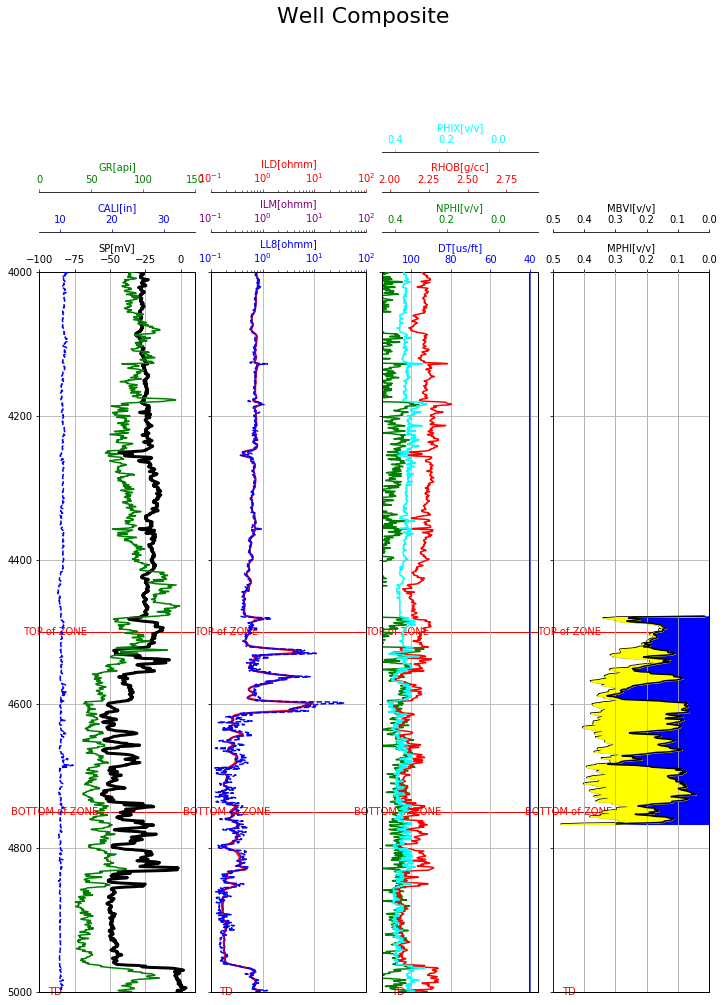

In [7]:


# =============================================================================
#      Display the logs for the whole well
# =============================================================================

triple_combo_plot(data.DEPT.min(),data.DEPT.max())



###### Second Zone Depths for Depth Plot

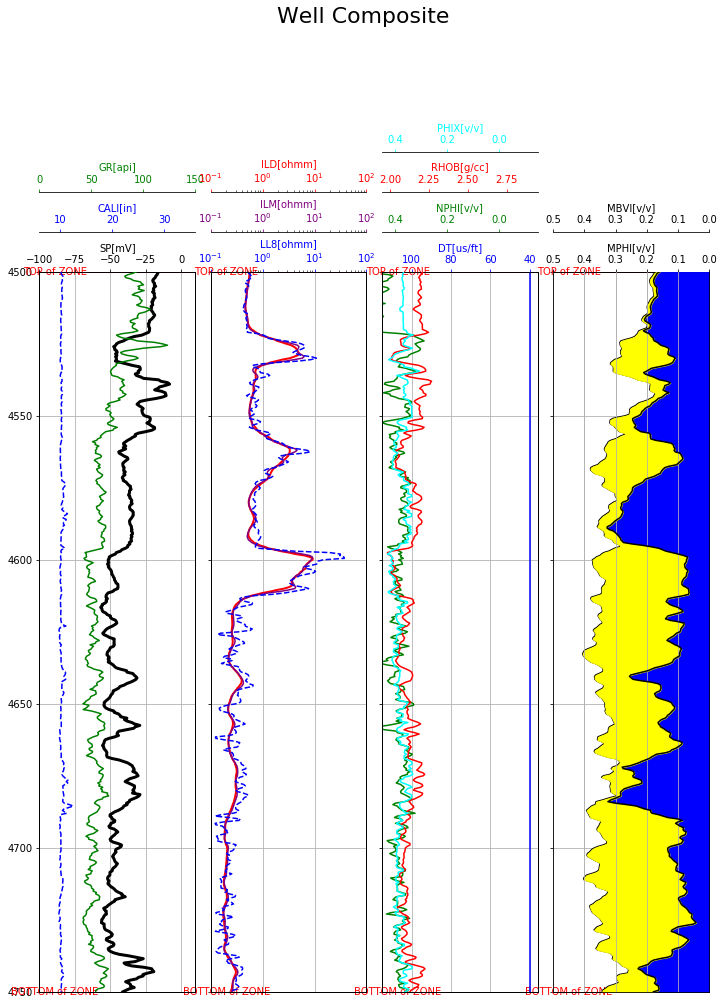

In [8]:
"""
===============================================================================
                    Major Zones of Interest
===============================================================================
===============================================================================
 a Main ZONE for analysis will be selected from the entire log. Program displays
 the logs again within the choosen interval with triple_combo_plot
 function.
 
 === Select zone of analysis: top and depth
 
 by setting the ``top_depth'' and ``bottom_depth'' variables
===============================================================================


# =============================================================================
# a ZONE for analysis will be selected from the entire log. Let’s display
# again the logs within the choosen interval with triple_combo_plot
# function.
# =============================================================================
"""


#Plot again using new Top and Bottom Depths. Could you do this with tops?
triple_combo_plot(top_depth,bottom_depth)




#### Calculate Shale Volumes

In [9]:
"""
===============================================================================
 === 3. Calculate Volume of Shale
 
 The first step of a basic well log analysis will begin with the volume
 of Shale calculation.
 
 There are several methods used to perform that, clasified as: - Single
 methods: Gamma Ray Log, Spontaneous Potential, vshrt or by - Dual
 Methods: Neutron-Density, it is based on a N-D Crossplot, where a clean
 line and a clay point will be defined, as you will see in the graphs
 below.
===============================================================================
"""
#vshgr
#---the setup below is correction = None or linear GR as recommended by Heslep
def vshgr(gr_log, gr_clean, gr_shale, correction=None):

    igr=(gr_log-gr_clean)/(gr_shale-gr_clean)      #Linear Gamma Ray
    vshgr_larionov_young=0.083*(2**(3.7*igr)-1)   #Larionov (1969) - Tertiary rocks
    vshgr_larionov_old=0.33*(2**(2*igr)-1)        #Larionov (1969) - Older rocks
    vshgr_clavier=1.7-(3.38-(igr+0.7)**2)**0.5    #Clavier (1971)
    vshgr_steiber=0.5*igr/(1.5-igr)               #Steiber (1969) - Tertiary rocks

    if correction == "young":
        vshgr=vshgr_larionov_young
    elif correction == "older":
        vshgr=vshgr_larionov_old
    elif correction=="clavier":
        vshgr=vshgr_clavier
    elif correction=="steiber":
        vshgr=vshgr_steiber
    else:
        vshgr=igr
    return vshgr

#vshsp
def vshsp(sp_log, sp_clean, sp_shale):
    vshsp=(sp_log-sp_clean)/(sp_shale-sp_clean)
    return vshsp

#vshrt
def vshrt(rt_log, rt_clean,rt_shale):
    vrt=(rt_shale/rt_log)*(rt_clean-rt_log)/(rt_clean-rt_shale)
    if (rt_log > 2* rt_shale):
        vshrt = 0.5 * (2 * vrt)** (0.67*(vrt+1)) 
    else:
        vshrt = vrt
    return vshrt


#vshnd
def vshnd(neut_log,den_log,neut_matrix,den_matrix,neut_fl,den_fl,neut_shale,den_shale):
    term1 = (den_fl-den_matrix)*(neut_log-neut_matrix)-(den_log-den_matrix)*(neut_fl-neut_matrix)
    term2 =(den_fl-den_matrix)*(neut_shale-neut_matrix)-(den_shale-den_matrix)*(neut_fl-neut_matrix)
    vshnd=term1/term2
    return vshnd


# ======= This was the original from Mahai and I do not use clay ==============
# neut_matrix, den_matrixtrix = 15, 2.6 #Define clean sand line 
# neut_fl, den_fl = 40, 2 
# =============================================================================

# Input parameters for Top and Bottom depths 
logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]

# calculate the vsh functions, by looping with pandas series values through vsh functions defined above
#  without looping - the function will throw an error

#initialize various Vsh
vshgr_temp,vshnd_temp, vshrt_temp, vshsp_temp =[],[],[],[]



# ===== this is an example of for a,b in zip(alist,blist): ====================
# alist = ['a1', 'a2', 'a3']
# blist = ['b1', 'b2', 'b3']
# 
# for a, b in zip(alist, blist):
#     print a, b
# 
# =============================================================================
# =============================================================================
# This is key for the input of log data to be used in Vsh calculations
# =============================================================================
for (i,j,k,l,m) in zip(logs.GR,logs.NPHI,logs.RHOB,logs.ILD,logs.SP):
    vshgr_temp.append(vshgr(i, gr_clean, gr_shale))
    vshnd_temp.append(vshnd(j,k,neut_matrix,den_matrix,neut_fl,den_fl,neut_shale,den_shale))    
    vshsp_temp.append(vshsp(m, sp_clean, sp_shale))
# =============================================================================
# This is the input of log data used in Vsh calculations
# =============================================================================
#======== test this as it prints GR, NPHI, RHOB, ILD, SP  =====================
#    print(i,j,k,l,m) #where i=GR, j=NPHI, k=RHOB, l=ILD and m=SP
#==============================================================================
    
logs.is_copy = False # without will throw an exception

logs['vshgr']=vshgr_temp
logs['vshnd']=vshnd_temp
logs['vshsp']=vshsp_temp
del vshgr_temp, vshnd_temp, vshsp_temp         #remove the arrays to free-up memory


C:\Users\craig\Anaconda3\lib\site-packages\pandas\core\generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\craig\Anaconda3\lib\site-packages\pandas\core\generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


###### Initial Interpretation Depth Plot and Histograms for parameter refinement

Text(0.5, 0, 'Vsh [v.v]')

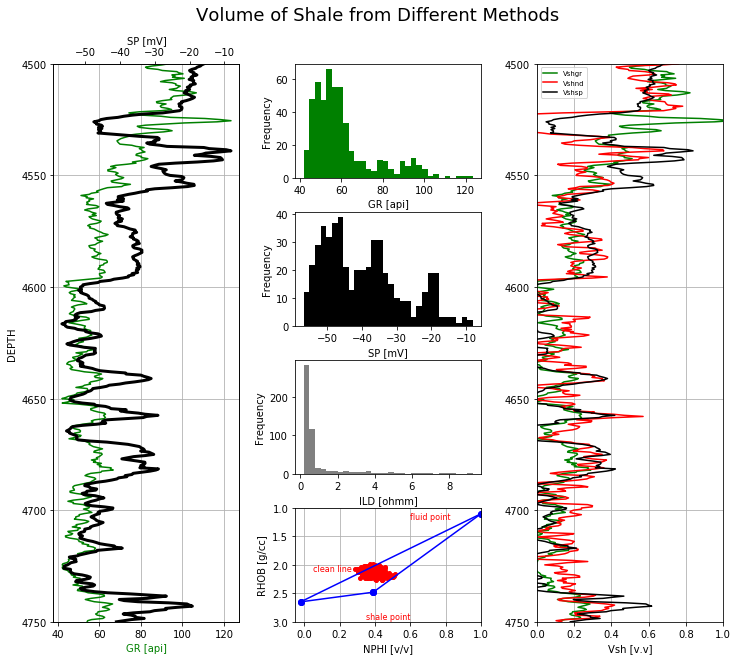

In [10]:
# =============================================================================
# We will create several displays (GR,SP vs DEPTH track, histograms, N-D
# crossplot, vsh track) in order to see and choose the right parameters
# for our clay/clean formations as well as to compare the results of all
# vsh methods calculated above.
# =============================================================================


from matplotlib import gridspec

#logs=data.iloc[[top_depth],[bottom_depth]]
#logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
#print (logs.GR,logs.LLD)
#Setting GRAPH ELEMENTS

fig = plt.figure(figsize=(12,10))
fig.suptitle('Volume of Shale from Different Methods',fontsize=18)
fig.subplots_adjust(top=0.90,wspace=0.3, hspace =0.3)

gs = gridspec.GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,1])
ax5 = fig.add_subplot(gs[3,1])
ax6 = fig.add_subplot(gs[:,2],sharey = ax1)


# Graph for GR,SP
ax1.invert_yaxis()
ax1.grid(True)
ax1.set_ylabel('DEPTH')
ax1.plot(logs.GR, logs.DEPT, color='green')
ax1.set_xlabel('GR [api]', color='green')

ax11=ax1.twiny()
ax11.plot(logs.SP, logs.DEPT, color='black', linewidth = 3.0)
ax11.set_xlabel("SP [mV]",color='black')


#The graph of GR histogram
ax2.hist(logs.GR.dropna(),bins=30,color='green')
ax2.set_xlabel('GR [api]')
ax2.set_ylabel('Frequency')

ax3.hist(logs.SP.dropna(),bins=30, color='black')
ax3.set_xlabel('SP [mV]')
ax3.set_ylabel('Frequency')

ax4.hist(logs.ILD.dropna(),bins=30, color='gray')
ax4.set_xlabel('ILD [ohmm]')
ax4.set_ylabel('Frequency')


# N-D XPlot for Volume of Shale
ax5.plot(logs.NPHI, logs.RHOB,'ro',markersize=4)
ax5.set_xlabel('NPHI [v/v]')
ax5.set_xlim(-.05,1.0)
ax5.set_ylim(3,1.0)
ax5.set_ylabel('RHOB [g/cc]')
ax5.grid(True)
ax5.text(0.05, 2.1, 'clean line', color='red', fontsize=8)
ax5.text(0.350, 2.95, 'shale point',color='red', fontsize=8)
ax5.text(0.6, 1.2, 'fluid point',color='red', fontsize=8)
# Plot Shale Triangle
ax5.plot([neut_matrix,neut_fl],[den_matrix,den_fl], marker='o', color='blue') # this is clean line
#ax5.plot([neut_matrix,1],[den_shaleale,1], marker='o', color='blue') #this is the clean line
ax5.plot([neut_matrix,neut_shale],[den_matrix,den_shale], marker='o', color='blue') #this is to the shale point
ax5.plot([neut_shale,1],[den_shale,den_fl], marker='o', color='blue') #this is from the shale point to 100% porosity line
ax5.plot(neut_shale,den_shale,'ro',color='blue')


#plt.title("Volume of Shale")
ax6.plot(logs.vshgr, logs.DEPT, label ='Vshgr',color="green")
ax6.plot(logs.vshnd, logs.DEPT,label ='Vshnd',color="red")
ax6.plot(logs.vshsp, logs.DEPT,label ='Vshsp',color="black")
ax6.legend(loc='best',fontsize='x-small')
ax6.set_xlim(0,1)
ax6.set_ylim(top_depth,bottom_depth)
ax6.invert_yaxis()
ax6.grid(True)
ax6.set_xlabel('Vsh [v.v]')

#plt.savefig ('vsh_plot.png', dpi=200, format='png')

# =============================================================================
# Use the histrograms to re-evaluate: - GR min, max (clean, clay) - SP
# min, max (clean, clay) - RT min, max (clean, clay) From ND Xplot extract
# the clean line and clay point.
# 
# All vshgr (you can apply any correction here), vshsp, vshrt and vshnd
# curves are plotted in the same track for comparison. It is obvious that
# the vshgr and vshnd match very well, comparing with the rest.
# 
# To simplify the intepretation we will accept the vshgr as the vsh.
# Another approch is to consider vsh as the minimum value obtained through
# several methods (vsh = min (vshgr,vshsp,vshnd)) or Hodges-Lehman Median Filter
# =============================================================================


###### Assign Shale Volume Method

In [11]:
logs['vsh']=(logs['vshnd']).clip(0,1)

#### Make Porosity Calculations

In [12]:
"""
===============================================================================
 === 4. The Porosity:
 
 Three logs are available for porosity estimation: sonic, density and
 neutron. Porosity can be evaluated by single or dual combinations of
 any three types mentioned: neutron-density, neutron-sonic and
 sonic-density. Basic porosity formulas are: - Sonic: Willie,
 Raymer-Hunt-Gardner; - Density; - Neutronic;
 
 The NEUTRON-DENSITY gives best result in any type of lithology
===============================================================================
"""

#Willie-TimeAverage
def phis_shale(dt_shale, dt_matrix, dt_fluid):
    phis_shale = (dt_shale-dt_matrix)/(dt_fluid-dt_matrix)
    return phis_shale
def phis_w(dt_log, dt_matrix, dt_fluid, cp):
    phis_w=(1/cp)*(dt_log-dt_matrix)/(dt_fluid-dt_matrix)
    return phis_w
def phis_w_sh_corr(dt_log, dt_matrix, dt_fluid, cp, dt_shale, vsh):
    phis_w=(1/cp)*(dt_log-dt_matrix)/(dt_fluid-dt_matrix)
    phis_w_sh = (dt_shale-dt_matrix)/(dt_fluid-dt_matrix)
    phis_w_sh_corr = phis_w - vsh * phis_w_sh
    return phis_w_sh_corr

#Raymer-Hunt-Gardner (the alpha(5/8) ranges from 0.625-0.70, 0.67-most, 0.60-gas reservoirs)
def phis_rhg(dt_log, dt_matrix, alpha):
    phis_rhg=(alpha)*(dt_log-dt_matrix)/(dt_log)
    return phis_rhg
def phis_rhg_sh_corr(dt_log, dt_matrix, dt_shale, vsh):
    phis_rhg=(5/8)*(dt_log-dt_matrix)/(dt_log)
    phis_rhg_sh = (dt_shale-dt_matrix)/(dt_fluid-dt_matrix)
    phis_rhg_sh_corr = phis_rhg - vsh * phis_rhg_sh
    return phis_rhg_sh_corr

#Density
def phid(den_log, den_matrix, den_fl, den_shale, vsh):
    phid = (den_log - den_matrix) / (den_fl - den_matrix)
    return phid
def phid_shale(den_shale, den_matrix, den_fl):
    phid_shale = (den_shale - den_matrix) / (den_fl - den_matrix)
    return phid_shale
def phid_sh_corr(den, den_matrix, den_fl, den_shale, vsh):
    phid = (den - den_matrix) / (den_fl - den_matrix)
    phid_sh = (den_shale - den_matrix) / (den_fl - den_matrix)
    phid_sh_corr = phid - vsh * phid_sh
    return phid_sh_corr

# NEUTRON:
def phin_sh_corr(neut, neut_sh, vsh):
    phin_sh_corr = (neut-vsh*neut_sh)
    return phin_sh_corr


#Neutron-Density
def phixnd(phinshc, phidshc):
    phixnd= (phinshc + phidshc) / 2
    return phixnd


def phixnd_gas_corr(phin, phid, phin_sh, phid_sh):
    phixnd_gas_corr= ((phin**2+phin**2)/2)**(0.5)    #for gas intervals (nphi<dphi = crossover)
    return phixnd_gas_corr


phis_sh=phis_shale(dt_shale, dt_matrix, dt_fluid)

#phid_sh=phis_shale(den_shale, den_matrix, den_fl) is this a type using phis_shale and not phid_shale???
phid_sh=phid_shale(den_shale, den_matrix, den_fl)

######phin_sh=45
phin_sh=neut_shale


#calculate the vsh functions, by looping with pandas series values through vsh functions defined above
logs['PHISw']=phis_w(logs.DT, dt_matrix, dt_fluid, cp)
logs['PHISwshc']=phis_w_sh_corr(logs.DT, dt_matrix, dt_fluid, cp, dt_shale, logs.vsh).clip(0,1)

logs['PHISrhg']=phis_rhg(logs.DT, dt_matrix, alpha)
logs['PHISrhgshc']=phis_rhg_sh_corr(logs.DT, dt_matrix, dt_shale, logs.vsh).clip(0,1)

logs['PHID']=phid(logs.RHOB, den_matrix, den_fl, den_shale, logs.vsh)
logs['PHIDshc']=phid_sh_corr(logs.RHOB, den_matrix, den_fl, den_shale, logs.vsh).clip(0,1)

logs['PHIN']=logs.NPHI
logs['PHINshc']=phin_sh_corr(logs.NPHI, phin_sh, logs.vsh).clip(0,1)

logs['PHIxND']=phixnd(logs.PHINshc,logs.PHIDshc).clip(0,1)



# A PHIxND porosity is a good estimation of effective porosity. Calculated
# porosities above are similar with core porosities (see
#     http://certmapper.cr.usgs.gov/data/PubArchives/OF00-200/WELLS/WALAKPA1/LAS/WA1LOG.JPG)

######logs['PHIE']=logs['PHIxND']

#logs['PHIT']=logs['PHIxND']
logs['PHIT']=((logs['PHID']+logs['NPHI'])/2).clip(0,1)
#logs['PHIT']=logs['Phixnd_chartbook']


#logs['PHIE']=logs['PHIT'] - por_shale*logs['vsh']
logs['CBW'] = (por_shale*logs['vsh']).clip(0,1)
logs['PHIE']=(logs['PHIT'] - por_shale*logs['vsh']).clip(0,1)


###### Swb and Qv calculations where Qv is used in Waxman-Smits saturation analysis

In [13]:
# Calculations for Swb used in Dual Water and WaxSmits
logs['Swb'] =( 1 - logs['PHIE']/logs['PHIT']).clip(0,1)

# Qv from Swb using Hill, Shirley and Klein
logs['Qv'] = (logs['Swb']/(0.6425/((den_fl*SAL)**0.5) +0.22)).clip(0,5)


###### Need to Calculate m* apparent to define the m* vs. Swb trend for wet samples and define m* (not working yet)

In [14]:
# =============================================================================
#
#                 This is not working
#
# Mstarapp=LOG10(RWG*A/(RT*(1+RWG*B*QV)))/LOG10(TPOR)
# logs['Mstarapp'] = math.log10(  rwa/logs['ILD']*(1+rwa*B*logs['Qv'])  )   /   math.log10(logs['PHIT'])
# logs['Mstarapp'] = math.log10(  rwa/logs['ILD']*(1+rwa*B*logs['Qv'])  )   /   10**(logs['PHIT'])
# 
# =============================================================================


#logs['term1'] =(  rwa/logs['ILD']*(1+rwa*B*logs['Qv'])  )   
#logs['term2'] = (logs['PHIT'])
#logs['Mstarapp']=math.log(10,logs['term1'])/math.log(10,logs['term2'])

logs['Mstarapp'] = m_cem + mslope*logs['Swb']


#### Water Saturation Calculations

In [15]:
"""
===============================================================================
 === 5. Water Saturation
 
 Before calculating the water saturation we need a value for the Rw(Resistivity of water)
 
 ===== Resistivity of water
 
 It can be determined from: - water catalogs - DST test water analysis -
 Rw from SP (needs information about Rmud and … ) - Rwa Method (Rw from a
 100% water zone)
 
 Assume that we have no ideea about the Rw of water, then best practice is a
 PICKETT plot. This plot is logarithmic plot using Gus Archie’s equation:
 
 ===== Archie Water Saturation Eq.
 
 Sw^n_sat = (a * Rw) / (Rt * PHI ^ m_cem)
 
 Equation can be re-write in a logarithm way and plotted in a log graph
 RT vs PHI:
 
 log(PHI) = - (1 / m_cem) * log(R_t) - n_sat * log(Sw) + log( a * Rw)

 IMO we should use 'a' = 1 since at 100% Porosity Ro/Rw = 1
"""
print()


###### Pickett Plot to define Archie m and Rw

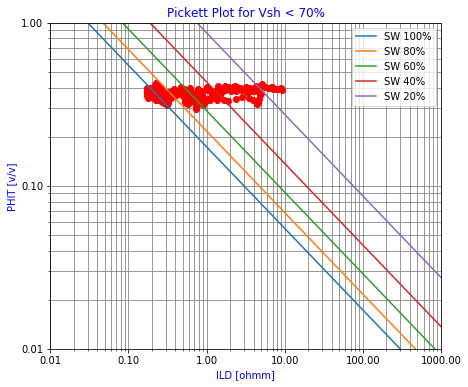

In [16]:
import matplotlib.ticker as ticker

pickett_figure=plt.figure(figsize=(7,6))
plt.title('Pickett Plot'+ ' for Vsh < '+str(int(vsh_limit*100))+'%', color = 'blue')
plt.loglog(logs.ILD[logs.vsh<vsh_limit],logs.PHIT[logs.vsh<vsh_limit],'ro', label='',color='red')
plt.xlim(0.01,1000)
plt.ylim(0.01,1)
plt.ylabel('PHIT [v/v]', color = 'blue')
plt.xlabel('ILD [ohmm]', color = 'blue')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

#calculate the saturation lines
sw_plot=(1.0,0.8,0.6,0.4,0.2)
phie_plot=(0.01,1)
rt_plot=np.zeros((len(sw_plot),len(phie_plot)))
                
for i in range (0,len(sw_plot)):
    for j in range (0,len(phie_plot)):
        rt_result=((1*rwa)/(sw_plot[i]**n_sat)/(phie_plot[j]**m_cem))
        rt_plot[i,j]=rt_result      
for i in range(0,len(sw_plot)):
    plt.plot(rt_plot[i],phie_plot, label='SW '+str(int(sw_plot[i]*100))+'%')
    plt.legend (loc='best')
plt.grid(True, which='both',ls='-',color='gray')

#plt.savefig('pickett.png', dpi=200, format='png')


######  Vshale vs. CBW to define the volume of Clay Bound Water that is used to correct PHIT to PHIE

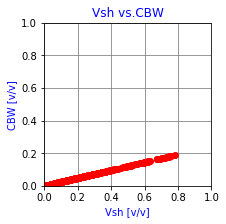

In [17]:
cbw_figure=plt.figure(figsize=(3,3))
plt.title('Vsh vs.CBW', color = 'blue')
plt.plot(logs.vsh,logs.CBW,'ro', label='',color='red')
plt.xlim(0.0,1)
plt.ylim(0.0,1)
plt.ylabel('CBW [v/v]', color = 'blue')
plt.xlabel('Vsh [v/v]', color = 'blue')
plt.grid(True, which='both',ls='-',color='gray')


###### Swb vs. m* apparent to define variation of  m*  with changes of Swb

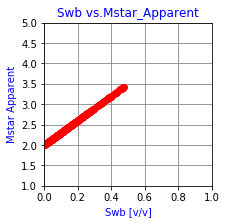

In [18]:
mapp_figure=plt.figure(figsize=(3,3))
plt.title('Swb vs.Mstar_Apparent', color = 'blue')
plt.plot(logs.Swb,logs.Mstarapp,'ro', label='',color='red')
plt.xlim(0.0,1)
plt.ylim(1.0,5)
plt.ylabel('Mstar Apparent', color = 'blue')
plt.xlabel('Swb [v/v]', color = 'blue')
plt.grid(True, which='both',ls='-',color='gray')

###### Saturation Calculations

In [19]:
# =============================================================================
# # From the Picket plot results we determine Rw.
# =============================================================================


# Add the equation in a function named: sw_archie,
def sw_archie(Rw, Rt, Poro, a, m_cem, n_sat):
        F = 1 / (Poro**m_cem)
        Sw_archie = (F * Rw/Rt)**(1/n_sat)
        return Sw_archie


def sw_dw(Rw, T, RwT, Rt, PHIT, PHIE, Swb, MBVI, MPHI):
        '''
        dualwater(Rw, Rt, PHIT, por_shale, Vsh, Rsh)
        **Dual-Water (clavier, 1977) with later modifications/rearrangements.
          Formulas from Doveton "Principles of mathematical petrophysics"
        *Input parameters:
         - PHIT - total porosity
         - por_shale - shale porosity
         - Rw - formation water resistivity [ohmm]
         - Swb - clay-bound water saturation 
         - Sw_dw - total water saturation
         *Returns:
         - Sw_dw - Total water saturation (or water saturation in Total pore space)
         - CBVWT - Coates DW CBW in Total Porossity system

         1. Coates, G.R., Gardner, J.S., and Miller, D.L., 1994, 
            Applying pulse-echo NMR to shaly sand formation evaluation, 
            paper B, 35th Annual SPWLA Logging Symposium Transactions, 22 p.
        '''

        #--------------------------------------------------
        #
        #  BEGINNING OF MRIAN AS PROPOSED BY COATES, et al
        #
        #----- COMPUTE BASIC DATA -------------------------
        #RwT = T
        CW = (T+7.)/(Rw*(RwT+7.))
        #----  CCW FROM COATES   
        CCW = 0.000216*(T-16.7)*(T+504.4)
        Ct   = 1/Rt
        #--------------------------------------------------
        #Swb = 1.0 - (PHIE/PHIT)
        Swia=MBVI/MPHI
        #Swia = Swb #estimate
        #--------------------------------------------------
        CBW = Swb * PHIT
        # MBVI in Total Porosity System
        BVIT  = MBVI + CBW
        SWBI  = CBW/PHIT
        #----- COMPUTE DCW ------------------------------
        ALPHA = 1 #for now with Salinity > 40,000 ppm
        DCWW=CW+ALPHA*Swb*(CCW-CW)
        DCWI=CW+ALPHA*SWBI*(CCW-CW)
        #----- W @ Sw = 1 -----------------------------------
        #WW=math.log10(Ct/DCWW)/(math.log10(PHIT))
        #----- W @ Sw AT BVI --------------------------------
        #WI=math.log10(Ct/DCWI)/(math.log10(BVIT))
        #----- THE ACTUAL W ---------------------------------
        Wq = 0.4*Swia + 1.65
        #Wq = 0.4*Swia + 1.9
        #----- WW AND WI CONSTRAN W ------------------------
        #----- COMPUTE CBVW TOTAL -----------------------
        #AA=CW
        #BB=ALPHA*(CBW)*(CW-CCW)
        #CC=Ct
        #CBVWA = (BB + math.sqrt(BB*BB + 4*AA*CC))/(2*AA)
        CBVWA = (ALPHA*(CBW)*(CW-CCW) + ((ALPHA*(CBW)*(CW-CCW))**2 + 4*CW*Ct)**(1/2))/(2*CW)
        CBVWT = CBVWA**(2/Wq)
        #---- COMPUTE Bulk Volume Water CBVWE in Effective System ----------
        #CBVWE = CBVWT-CBW    
        Sw_dw = CBVWT/PHIT
        return Sw_dw
        #------------------------------------------------------------
        #      END OF GEORGE COATES' MRIAN                                        
        #-------------------------------------------------------------

def waxmansmits(Rw, T, RwT, Rt, PHIT, PHIE, den_fl, m_cem, mslope, Swb, Rw75, Qv, B):
        '''
        waxmansmits(Rw, Rt, PhiT, aa, mm, CEC)
        **Waxman-Smits CEC method obtains Qv from Hill, Shirley and Klein
          Eq solved for n=2
        *Input parameters:
         - PHIT - total porosity
         - m_cem -  cementation exponent is adjusted for Swb
         - Rw - formation water resistivity ohmm
         - B - cation mobility (mho cm2 / meq)
         - Qv - concentration of exchange cations per volume unit (meq/ml pore space)
         - CEC - cation exchange capacity of shale(meq/100 gm of sample)
         - den_ma - mineral graind density (g/cc)
         - m_cem - best determined from SCAL      
        *Returns:
         - Sw_Total_WS - total water saturation from Waxman-Smits
         - Sw_WS =(  ((1/PHIT**mstar)*Rw)/Rt*(1+Rw*B*QV)/Sw )**(1/nstar)
        '''
        
        #convert m_cem to mstar with increase in mstar with increase in Swb
        mstar = m_cem + mslope*Swb

        #Crain's Waxman-Smits in lieu of using iterative. 
        #Swc = 0.5 * ((- B * Qv * RW2) + ((B * Qv *  RW2)**2 + 4 * F * RW@FT / RESD) ^ 0.5)**(2 / N)
        swT = 0.5 * (    (- B*Qv*Rw75) + (  (B*Qv*Rw75)**2  +  4*(1/PHIT**mstar)*Rw/Rt)**0.5)**(2/2)
        return swT


Rw =rwa

logs['Sw_archie']=(sw_archie(Rw,logs.ILD,logs.PHIT,1,m_cem,n_sat)).clip(0,1)
#Calculate the BVW (bulk volume of water) for Archie:
logs['BVW']=(logs['Sw_archie']*logs['PHIT']).clip(0,1)

logs['Sw_dw'] =(sw_dw(Rw, T, RwT, logs.ILD, logs.PHIT, logs.PHIE, logs.Swb,logs.MBVI, logs.MPHI)).clip(0,1)
#Calculate the BVW Effective for DW:
logs['CBVWE']=(logs['Sw_dw']*logs['PHIT'] - logs['CBW']).clip(0,1)

logs['Sw_ws'] =(waxmansmits(Rw, T, RwT, logs.ILD, logs.PHIT, logs.PHIE, den_fl, m_cem, mslope, logs.Swb, Rw75, logs.Qv, Bdacy)).clip(0,1)
logs['WSCBVWE']=(logs['Sw_ws']*logs['PHIT'] - logs['CBW']).clip(0,1)

logs['matrix']=(1-logs.vsh*por_shale-logs.PHIE).clip(0,1)


#### Interpretation Depth Plot

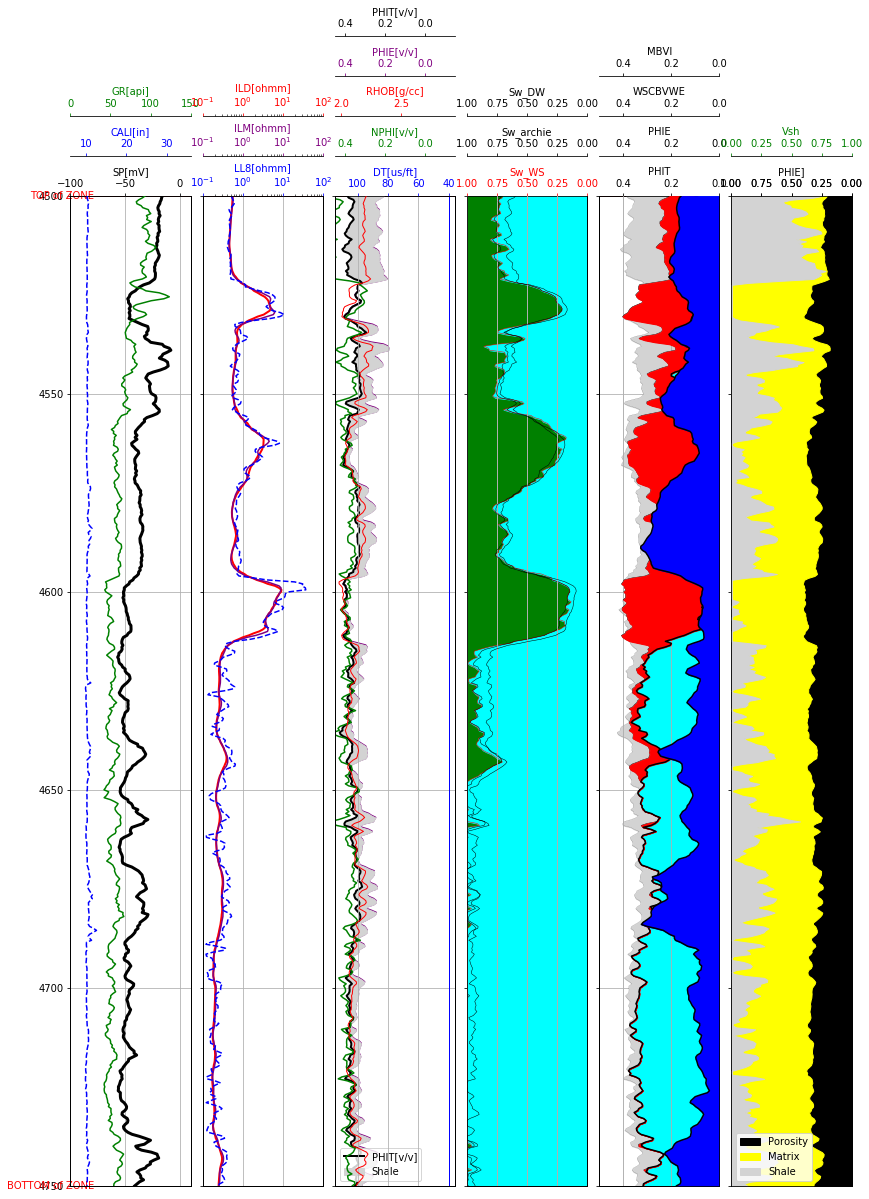

In [20]:
"""
===============================================================================
 === 6. Display the ``Interpretation Plot''
 
 Create a plot template and add the results of volume of shale, saturation and porosity.
===============================================================================
"""
import matplotlib.pyplot as plt


# Create the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(14,22), sharey=True)
#fig.suptitle("Final Interpretation Depth Plot over Zone of Interest", fontsize=22)
fig.subplots_adjust(top=0.75,wspace=0.1)

##General setting for all axis per Mahai
#for axes in ax:
#    axes.set_ylim (top_depth,bottom_depth)
#    axes.invert_yaxis()
#    axes.yaxis.grid(True)
#    axes.get_xaxis().set_visible(False)
#    for i in tops_depths:
#            if ((i>=top_depth) and (i<=bottom_depth)):
#                axes.axhline(y=i, linewidth=1.0, color='red')
#for (i,j) in zip(tops_depths,tops):
#    if ((i>=top_depth) and (i<=bottom_depth)):
#        ax[0].text(0.2, i ,j, horizontalalignment='right',verticalalignment='center', color='red')        

#General setting for all axis concentrating only on the Zone of Interest
for axes in ax:
    axes.set_ylim (top_summary,bottom_summary)
    #axes.set_ylim (top_depth,bottom_depth)
    axes.invert_yaxis()
    axes.yaxis.grid(True)
    axes.get_xaxis().set_visible(False)
    for i in tops_depths:
            if ((i>=top_summary) and (i<=bottom_summary)):
                axes.axhline(y=i, linewidth=1.0, color='red')
for (i,j) in zip(tops_depths,tops):
    if ((i>=top_summary) and (i<=bottom_summary)):
        ax[0].text(0.2, i ,j, horizontalalignment='right',verticalalignment='center', color='red')                

        
"""
#1st track: GR, SP, CALI track
"""
ax01=ax[0].twiny()
ax01.set_xlim(-100,10)
ax01.plot(logs.SP, logs.DEPT, label='SP[mV]', color='black',linewidth=3.0)
ax01.set_xlabel('SP[mV]',color='black')    
ax01.tick_params(axis='x', colors='black')
    
ax02=ax[0].twiny()
ax02.set_xlim(6,36)
ax01.grid(True)
ax02.plot(logs.CALI, logs.DEPT, '--', label='CALI[in]', color='blue') 
ax02.spines['top'].set_position(('outward',40))
ax02.set_xlabel('CALI[in]',color='blue')    
ax02.tick_params(axis='x', colors='blue')
    
ax03=ax[0].twiny()
ax03.set_xlim(0,150)
ax03.plot(logs.GR, logs.DEPT, label='GR[api]', color='green') 
ax03.spines['top'].set_position(('outward',80))
ax03.set_xlabel('GR[api]',color='green')    
ax03.tick_params(axis='x', colors='green')


"""
#2nd track: Resistivities
"""
ax11=ax[1].twiny()
ax11.set_xlim(0.1,100)
ax11.set_xscale('log')
ax11.grid(True)
ax11.spines['top'].set_position(('outward',80))
ax11.set_xlabel('ILD[ohmm]', color='red')
ax11.plot(logs.ILD, logs.DEPT, label='ILD[ohmm]', color='red', linewidth = 2.0)
ax11.tick_params(axis='x', colors='red')    

ax12=ax[1].twiny()
ax12.set_xlim(0.1,100)
ax12.set_xscale('log')
ax12.plot(logs.ILM, logs.DEPT, label='ILM[ohmm]', color='purple') 
ax12.spines['top'].set_position(('outward',40))
ax12.set_xlabel('ILM[ohmm]', color='purple')    
ax12.tick_params(axis='x', colors='purple')
    
ax13=ax[1].twiny()
ax13.set_xlim(0.1,100)
ax13.set_xscale('log')
ax13.plot(logs.LL8, logs.DEPT, '--',label='LL8[ohmm]', color='blue') 
ax13.spines['top'].set_position(('outward',0))
ax13.set_xlabel('LL8[ohmm]',color='blue')
ax13.tick_params(axis='x', colors='blue')


"""
#3rd track: DT, RHOB, NPHI track
"""
ax21=ax[2].twiny()
ax21.set_xlim(-0.15,0.45)
ax21.invert_xaxis()
ax21.plot(logs.PHIE, logs.DEPT, label='PHIE[v/v]', color='purple',linewidth=2.0) 
ax21.spines['top'].set_position(('outward',120))
ax21.set_xlabel('PHIE[v/v]', color='purple')    
ax21.tick_params(axis='x', colors='purple') 
#ax21.legend(loc='lower left')

ax22=ax[2].twiny()
ax22.set_xlim(-0.15,0.45)
ax22.invert_xaxis()
ax22.plot(logs.PHIT, logs.DEPT, label='PHIT[v/v]', color='black',linewidth=2.0) 
ax22.spines['top'].set_position(('outward',160))
ax22.set_xlabel('PHIT[v/v]', color='black')    
ax22.tick_params(axis='x', colors='black') 
ax22.fill_betweenx(logs.DEPT,logs.PHIE,logs.PHIT,color='lightgray',label='Shale')
ax22.legend(loc='lower left')

ax23=ax[2].twiny()
ax23.grid(True)
ax23.set_xlim(115,36)
ax23.spines['top'].set_position(('outward',0))
ax23.set_xlabel('DT[us/ft]')
ax23.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue',linewidth=1.0)
ax23.set_xlabel('DT[us/ft]', color='blue')    
ax23.tick_params(axis='x', colors='blue')
#ax23.legend(loc='lower left')
    
ax24=ax[2].twiny()
ax24.set_xlim(-0.15,0.45)
ax24.invert_xaxis()
ax24.plot(logs.NPHI, logs.DEPT, label='NPHI[v/v]', color='green') 
ax24.spines['top'].set_position(('outward',40))
ax24.set_xlabel('NPHI[v/v]', color='green')    
ax24.tick_params(axis='x', colors='green')
#ax24.legend(loc='lower left')
    
ax25=ax[2].twiny()
ax25.set_xlim(1.95,2.95)
ax25.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red',linewidth=1.0) 
ax25.spines['top'].set_position(('outward',80))
ax25.set_xlabel('RHOB[g/cc]',color='red')
ax25.tick_params(axis='x', colors='red')
#ax25.legend(loc='lower left')


"""
#4th track: SW
"""
ax31=ax[3].twiny()
ax31.grid(True)
ax31.set_xlim(1,0)
ax31.plot(logs.Sw_ws, logs.DEPT, label='Sw_ws', color='red',linewidth=0.5)
#ax33.plot(logs.SWs, logs.DEPT, label='SWs', color='green',linewidth=0.5)
ax31.fill_betweenx(logs.DEPT,1,logs.Sw_ws,color='green',label='Sw_ws')
ax31.fill_betweenx(logs.DEPT,0,logs.Sw_ws,color='cyan',label='Sw_ws')
ax31.spines['top'].set_position(('outward',0))
ax31.set_xlabel('Sw_WS', color='red')    
ax31.tick_params(axis='x', colors='red')


ax32=ax[3].twiny()
ax32.grid(True)
ax32.set_xlim(1,0)
ax32.plot(logs.Sw_archie, logs.DEPT, label='Sw_archie', color='black',linewidth=0.5)
#ax32.plot(logs.SWs, logs.DEPT, label='SWs', color='green',linewidth=0.5)
ax32.spines['top'].set_position(('outward',40))
ax32.set_xlabel('Sw_archie', color='black')    
ax32.tick_params(axis='x', colors='black')

ax33=ax[3].twiny()
ax33.grid(True)
ax33.set_xlim(1,0)
ax33.plot(logs.Sw_dw, logs.DEPT, label='Sw_dw', color='black',linewidth=0.5)
#ax33.plot(logs.SWs, logs.DEPT, label='SWs', color='green',linewidth=0.5)
ax33.spines['top'].set_position(('outward',80))
ax33.set_xlabel('Sw_DW', color='black')    
ax33.tick_params(axis='x', colors='black')


"""
#5th track: PHIE, BVW
"""
ax41=ax[4].twiny()
ax41.grid(True)
ax41.set_xlim(0.5,0)
ax41.plot(logs.PHIT, logs.DEPT, label='PHIT', color='black', linewidth=0.1)
ax41.fill_betweenx(logs.DEPT,logs.PHIT, logs.PHIE,color='lightgray',label= 'CBW')
ax41.spines['top'].set_position(('outward',0))
ax41.set_xlabel('PHIT', color='black')    
ax41.tick_params(axis='x', colors='black')

ax42=ax[4].twiny()
ax42.grid(True)
ax42.set_xlim(0.5,0)
ax42.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black', linewidth=0.5)
ax42.fill_betweenx(logs.DEPT,0,logs.WSCBVWE,color='cyan',label= 'Water')
ax42.spines['top'].set_position(('outward',40))
ax42.set_xlabel('PHIE', color='black')    
ax42.tick_params(axis='x', colors='black')

ax43=ax[4].twiny()
ax43.set_xlim(0.5,0)
ax43.plot(logs.WSCBVWE, logs.DEPT, label='WS BVWE', color='black')
ax43.fill_betweenx(logs.DEPT,logs.PHIE, logs.WSCBVWE,color='red',label= 'HC')
#ax43.fill_betweenx(logs.DEPT,logs.MBVI, 0,color='darkblue',label= 'MBVI')
ax43.spines['top'].set_position(('outward',80))
ax43.set_xlabel('WSCBVWE', color='black')    
ax43.tick_params(axis='x', colors='black')

ax44=ax[4].twiny()
ax44.set_xlim(0.5,0)
ax44.plot(logs.MBVI, logs.DEPT, label='MBVI', color='black')
#ax44.fill_betweenx(logs.DEPT,logs.PHIE, logs.WSCBVWE,color='red',label= 'HC')
ax44.fill_betweenx(logs.DEPT,logs.MBVI, 0,color='blue',label= 'MBVI')
ax44.spines['top'].set_position(('outward',120))
ax44.set_xlabel('MBVI', color='black')    
ax44.tick_params(axis='x', colors='black')



"""
#6th track: PHIE, MATRIX, Shale
"""
ax50=ax[5].twiny()
ax50.set_xlim(1,0)
ax50.spines['top'].set_position(('outward',0))
ax50.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black',linewidth=0.5)
ax50.set_xlabel('PHIE]', color='black')    
ax50.tick_params(axis='x', colors='black')

ax51=ax[5].twiny()
ax51.set_xlim(0,1)
ax51.spines['top'].set_position(('outward',40))
ax51.plot(logs.vsh, logs.DEPT, label='Vsh', color='green',linewidth=0.5)
ax51.set_xlabel('Vsh', color='green')    
ax51.tick_params(axis='x', colors='green')

ax52=ax[5].twiny()
ax52.set_xlim(1,0)
ax52.spines['top'].set_position(('outward',0))
ax52.fill_betweenx(logs.DEPT,0,logs.PHIE,color='black',label='Porosity')
ax52.fill_betweenx(logs.DEPT,logs.PHIE,1-logs.vsh,color='yellow',label='Matrix')
ax52.fill_betweenx(logs.DEPT,1-logs.vsh,1,color='lightgray',label= 'Shale')
ax52.legend(loc='lower left')

#plt.savefig ('interpretation_plot.png', dpi=200, format='png')

#### Summary Plots

MAIN ZONE of INTEREST: 4500 to 4750 feet
Mean values:


Sw_ws      0.771797
vsh        0.216743
PHIE       0.311023
WSCBVWE    0.226462
dtype: float64

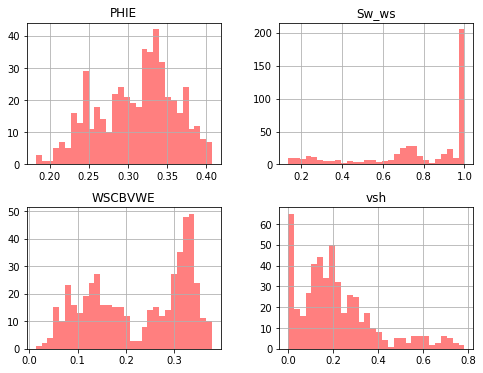

In [21]:
"""
===============================================================================
 == 7. Summary Plots
 
 A small example of an average properties over an interval, can be done as follows:
 
==============================================================================
"""

logs.loc[top_summary:bottom_summary,{'PHIE','Sw_ws','WSCBVWE','vsh'}].hist(figsize=(8, 6),alpha=0.5,bins=30,color='red')
print ('MAIN ZONE of INTEREST:', top_summary, 'to', bottom_summary, 'feet')
print ('Mean values:')
logs.loc[top_summary:bottom_summary,{'PHIE','Sw_ws','WSCBVWE','vsh'}].mean()



#### Save Data

In [22]:
#Then we can incorporate our calculated logs into the main pandas dataframe:

curves_to_export={'PHIE','Sw_ws','BVW','vsh'}
for x in curves_to_export:
    data[x] =logs[x]


#You have the option to export the dataframe to a csv file:



logs.to_csv('GulfCoast Well Logs.csv', encoding='utf-8')


#or you can export it to Excel:



from pandas import ExcelWriter

writer=ExcelWriter('GulfCoast Well Logs.xlsx')
logs.to_excel(writer, sheet_name='Logs', index=True)
writer.save()

1. Coates, G.R., Gardner, J.S., and Miller, D.L., 1994, "Applying pulse-echo NMR to shaly sand formation evaluation", paper B, 35th Annual SPWLA Logging Symposium Transactions, 22 p.

2. Hill, H.J., Shirley, O.J., Klein, G.E.: “Bound Water in Shaley Sands - Its Relation to Qv and Other Formation Properties”, Log Analyst, May-June 1979.

3. Dacy, J., Martin, P.: "Practical Advances in Core-Based Water Saturation Analysis of Shaly Tight Gas Sands", SCA, SCA2009-29, 2009.